# Project: House Property Sales Time Series

In [95]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs
print(torch.cuda.get_device_name(0))  # GPU model

True
1
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import os

# Asssessment
from pandas.plotting import scatter_matrix

# Models
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Data Downloading

In [97]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("htagholdings/property-sales")

print("Path to dataset files:", path)

Path to dataset files: /home/asus-creator/.cache/kagglehub/datasets/htagholdings/property-sales/versions/3


In [98]:
os.listdir("/home/asus-creator/.cache/kagglehub/datasets/htagholdings/property-sales/versions/3")

['raw_sales.csv', 'ma_lga_12345.csv']

In [99]:
df_ma = pd.read_csv(path + "/ma_lga_12345.csv")
df_raw = pd.read_csv(path + "/raw_sales.csv")

## Data Assessement

In [100]:
df_ma.head(20)

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2
5,31/12/2008,440256,house,2
6,31/03/2009,442566,house,2
7,30/06/2009,446113,house,2
8,30/09/2009,440123,house,2
9,31/12/2009,442131,house,2


In [101]:
df_raw.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [102]:
df_ma.describe()

,MA,bedrooms
count,3.470000e+02,347.000000
mean,5.481320e+05,2.867435
std,1.701934e+05,1.239875
min,3.167510e+05,1.000000
25%,4.277395e+05,2.000000
50%,5.077440e+05,3.000000
75%,6.275155e+05,4.000000
max,1.017752e+06,5.000000


In [103]:
df_raw.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


In [104]:
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   saledate  347 non-null    object
 1   MA        347 non-null    int64 
 2   type      347 non-null    object
 3   bedrooms  347 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.0+ KB


In [105]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [106]:
df_ma.isnull().sum()

saledate    0
MA          0
type        0
bedrooms    0
dtype: int64

In [107]:
df_raw.isnull().sum()

datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

In [108]:
print(df_ma.columns)
print(df_raw.columns)


Index(['saledate', 'MA', 'type', 'bedrooms'], dtype='object')
Index(['datesold', 'postcode', 'price', 'propertyType', 'bedrooms'], dtype='object')


### Data Vizualization

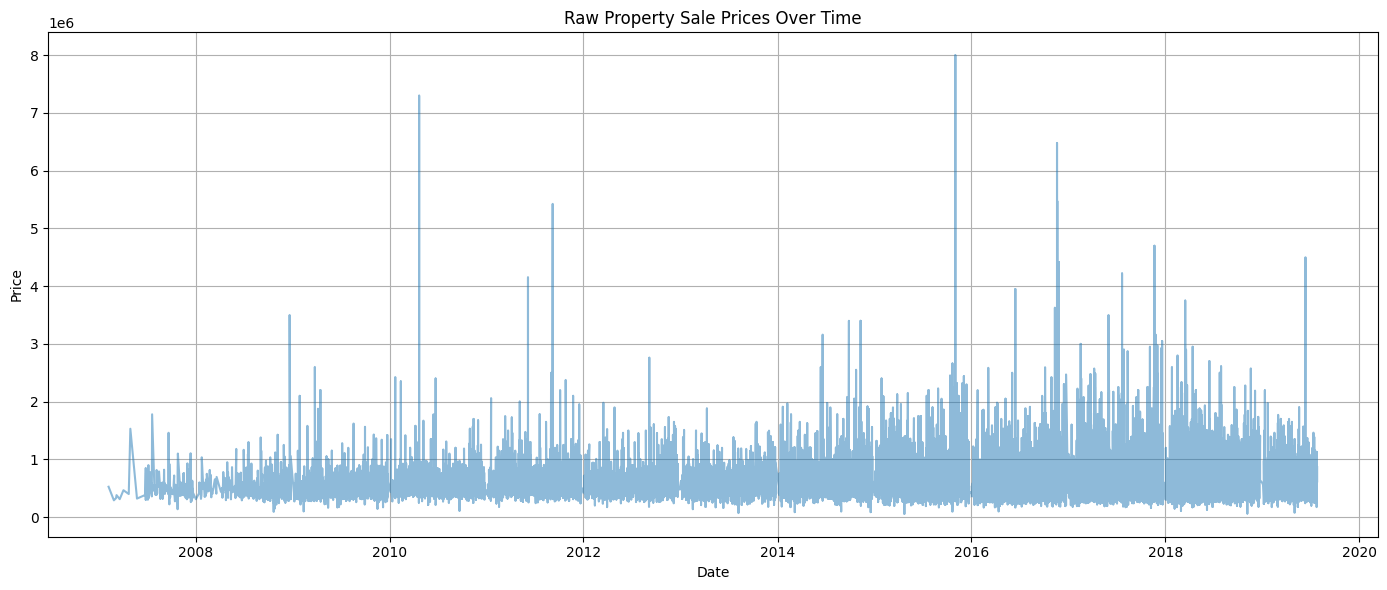

In [109]:
# Plot raw prices
df_raw.columns = df_raw.columns.str.strip()
df_raw['datesold'] = pd.to_datetime(df_raw['datesold'])
df_raw = df_raw.sort_values(by='datesold')

plt.figure(figsize=(14, 6))
plt.plot(df_raw['datesold'], df_raw['price'], label='Raw Sale Prices', alpha=0.5)
plt.title('Raw Property Sale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4775/1641994868.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])


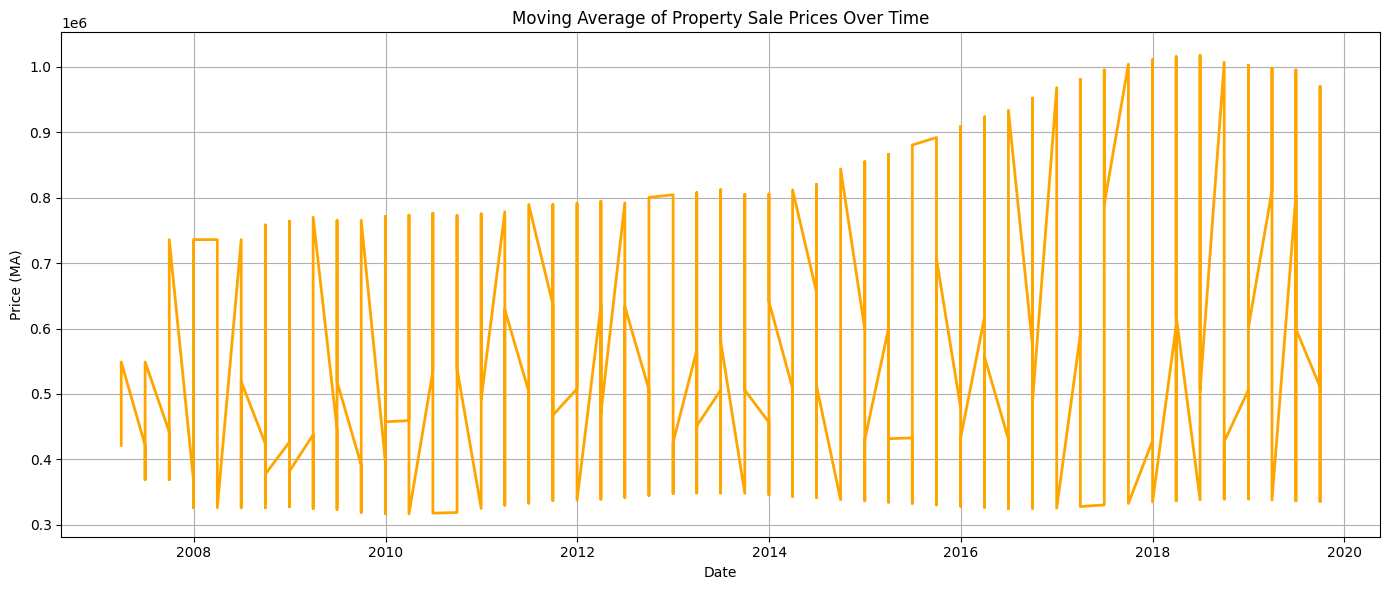

In [110]:
df_ma.columns = df_ma.columns.str.strip()
df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])
df_ma = df_ma.sort_values(by='saledate')

plt.figure(figsize=(14, 6))
plt.plot(df_ma['saledate'], df_ma['MA'], label='Moving Average Price', color='orange', linewidth=2)
plt.title('Moving Average of Property Sale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (MA)')
plt.grid(True)
plt.tight_layout()
plt.show()


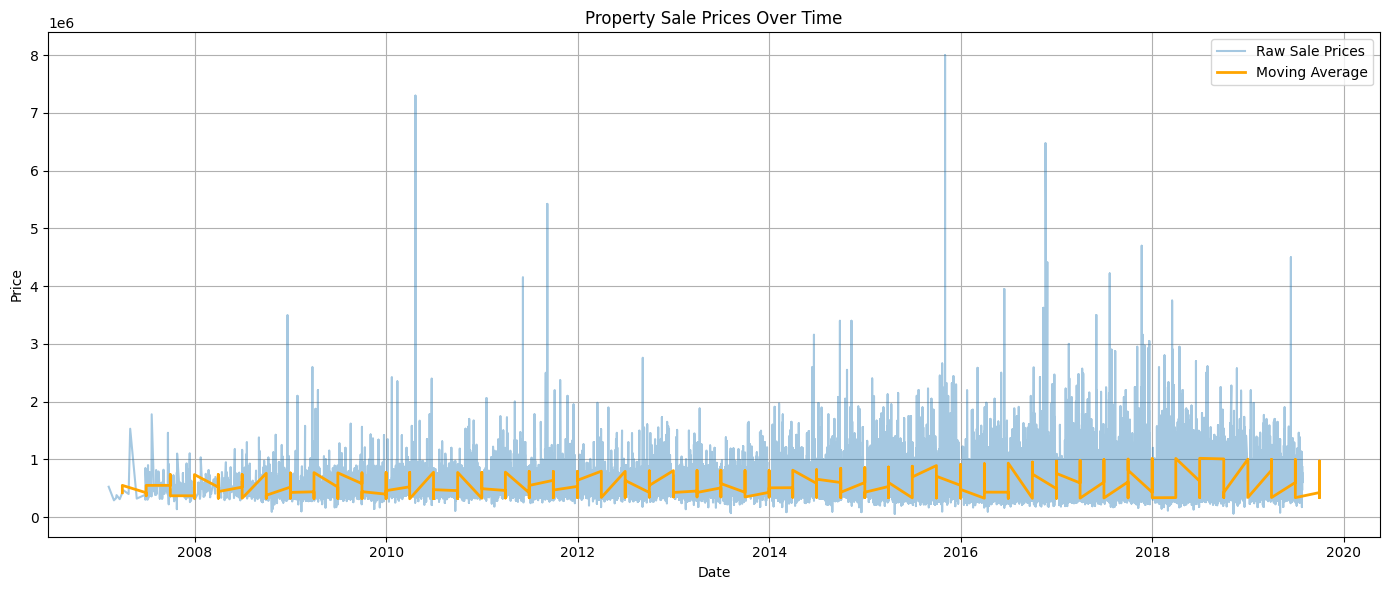

In [111]:
df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])
df_raw['datesold'] = pd.to_datetime(df_raw['datesold'])

df_ma = df_ma.sort_values(by='saledate')
df_raw = df_raw.sort_values(by='datesold')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_raw['datesold'], df_raw['price'], label='Raw Sale Prices', alpha=0.4)
plt.plot(df_ma['saledate'], df_ma['MA'], label='Moving Average', linewidth=2, color='orange')

plt.title('Property Sale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Data Preprocessing

In [112]:
ts = df_ma['MA'].values.reshape(-1, 1)

In [113]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

In [114]:
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(x), np.array(y)

In [115]:
x, y = create_sequences(ts_scaled, seq_len = 12)

In [116]:
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]

#### Building LSTM Model

In [117]:
model = Sequential([
    GRU(64, activation='tanh', input_shape=(12, 1)),
    Dense(1)
])

/home/asus-creator/MLC/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [118]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [119]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0815 - val_loss: 0.1089
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0568 - val_loss: 0.1150
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0524 - val_loss: 0.1067
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0479 - val_loss: 0.1083
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0539 - val_loss: 0.1052
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0500 - val_loss: 0.1058
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0549 - val_loss: 0.1132
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0498 - val_loss: 0.1041
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0502 - val_loss: 0.1051
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0455 - val_loss: 0.1079
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0464 - val_loss: 0.1116
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0450 - val_l

## Model Evaluation

In [120]:
y_pred = model.predict(x_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


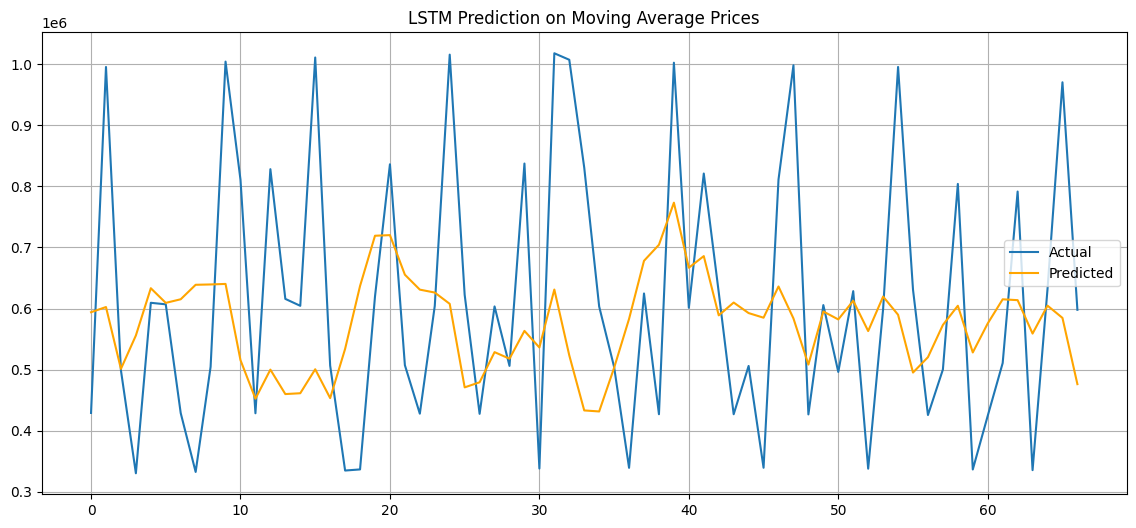

In [121]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', color='orange')
plt.legend()
plt.title('LSTM Prediction on Moving Average Prices')
plt.grid(True)
plt.show()

In [122]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 177434.19
Mean Squared Error (MSE): 48558887687.99
Root Mean Squared Error (RMSE): 220360.81
R² Score: -0.04
